[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Precision: 0.8432908374942443
Recall: 0.8537041587108007
F1-Score: 0.8462009582667909


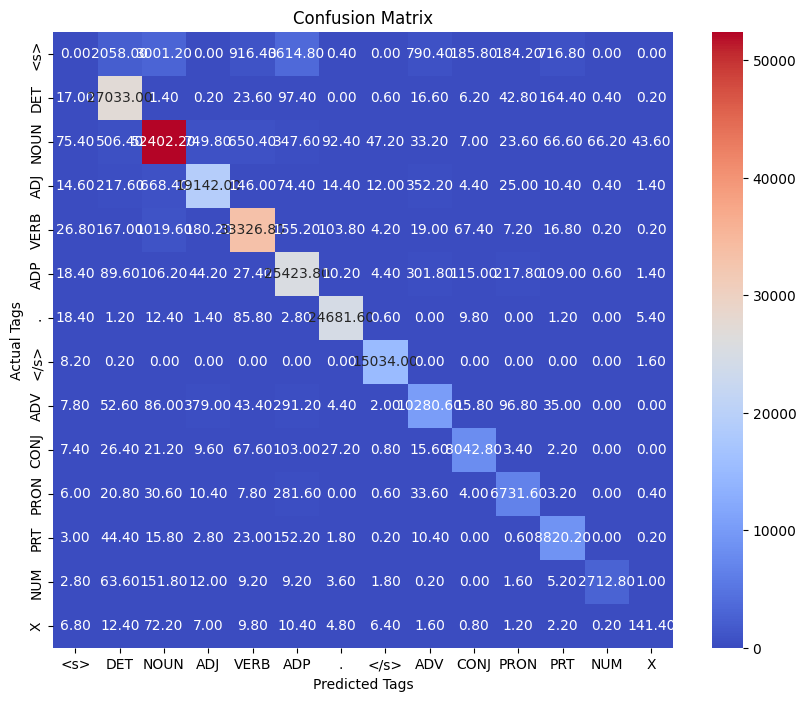


Model trained. You can now input sentences for NER tagging.

Enter a sentence for POS tagging (or type 'exit' to quit): I am Nitesh Singh

POS Tags:
i: PRON
am: VERB
nitesh: DET
singh: NOUN


In [ ]:
import numpy as np
import nltk
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('brown')
nltk.download('universal_tagset')
from nltk.corpus import brown

# Load dataset
sentences = brown.tagged_sents(tagset='universal')

# Preprocessing: Lowercasing and tokenization
def preprocess(sentences):
    return [[('<s>', '<s>')] + [(word.lower(), tag) for word, tag in sentence] + [('</s>', '</s>')] for sentence in sentences]

data = preprocess(sentences)

# Train-Test Split (k-fold cross-validation)
def split_data(data, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_idx, test_idx in kf.split(data):
        train_data = [data[i] for i in train_idx]
        test_data = [data[i] for i in test_idx]
        yield train_data, test_data

# Create transition and emission probabilities
def train_hmm(train_data):
    tags = []
    words = []
    for sentence in train_data:
        tags.extend([tag for _, tag in sentence])
        words.extend([word for word, _ in sentence])

    tag_counts = nltk.FreqDist(tags)
    word_tag_counts = nltk.ConditionalFreqDist((tag, word) for sentence in train_data for word, tag in sentence)
    tag_bigram_counts = nltk.ConditionalFreqDist(nltk.bigrams(tags))

    # Transition probabilities
    transition_probs = {tag: {next_tag: (tag_bigram_counts[tag][next_tag] / tag_counts[tag]) for next_tag in tag_counts} for tag in tag_counts}

    # Emission probabilities
    emission_probs = {tag: {word: (word_tag_counts[tag][word] / tag_counts[tag]) for word in word_tag_counts[tag]} for tag in tag_counts}

    return tag_counts.keys(), transition_probs, emission_probs

# Viterbi Algorithm
def viterbi(sentence, tags, transition_probs, emission_probs):
    tags = list(tags)  # Convert dict_keys to a list
    n = len(sentence)
    m = len(tags)

    viterbi_table = np.zeros((m, n))
    backpointer = np.zeros((m, n), dtype=int)

    # Initialization
    for i, tag in enumerate(tags):
        if tag != '<s>':
            viterbi_table[i, 0] = transition_probs['<s>'].get(tag, 1e-6) * emission_probs[tag].get(sentence[0], 1e-6)

    # Recursion
    for t in range(1, n):
        for i, tag in enumerate(tags):
            probabilities = [viterbi_table[j, t - 1] * transition_probs[prev_tag].get(tag, 1e-6) * emission_probs[tag].get(sentence[t], 1e-6) for j, prev_tag in enumerate(tags)]
            viterbi_table[i, t] = max(probabilities)
            backpointer[i, t] = np.argmax(probabilities)

    # Termination
    best_path = []
    last_state = np.argmax(viterbi_table[:, n - 1])
    best_path.append(tags[last_state])

    for t in range(n - 1, 0, -1):
        last_state = backpointer[last_state, t]
        best_path.append(tags[last_state])

    return list(reversed(best_path))

# Evaluation Metrics
def evaluate(test_data, tags, transition_probs, emission_probs):
    y_true, y_pred = [], []
    for sentence in test_data:
        words, true_tags = zip(*sentence)
        predicted_tags = viterbi(words, tags, transition_probs, emission_probs)
        y_true.extend(true_tags)
        y_pred.extend(predicted_tags)

    # Precision, Recall, F-Scores
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(tags))

    return precision, recall, fscore, cm

# Main Function
all_precision, all_recall, all_fscore, all_cm = [], [], [], []

for train_data, test_data in split_data(data, k=5):
    tags, transition_probs, emission_probs = train_hmm(train_data)
    precision, recall, fscore, cm = evaluate(test_data, tags, transition_probs, emission_probs)
    all_precision.append(precision)
    all_recall.append(recall)
    all_fscore.append(fscore)
    all_cm.append(cm)

# Average Results
print("Precision:", np.mean(all_precision))
print("Recall:", np.mean(all_recall))
print("F1-Score:", np.mean(all_fscore))

# Plot Confusion Matrix (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(np.mean(all_cm, axis=0), annot=True, fmt=".2f", cmap="coolwarm", xticklabels=tags, yticklabels=tags)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Tags")
plt.ylabel("Actual Tags")
plt.show()

# Interactive POS Tagging
print("\nModel trained. You can now input sentences for NER tagging.")
while True:
    sentence = input("\nEnter a sentence for POS tagging (or type 'exit' to quit): ")
    if sentence.lower() == 'exit':
        break
    words = sentence.lower().split()
    pos_tags = viterbi(words, tags, transition_probs, emission_probs)
    print("\nPOS Tags:")
    for word, tag in zip(words, pos_tags):
        print(f"{word}: {tag}")
